In [2]:
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from torch.nn.parallel import DataParallel
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

emotions_data = pd.read_csv('/content/drive/My Drive/Emotion/emotions.csv')
emotions_data.head(3)


Mounted at /content/drive


,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4


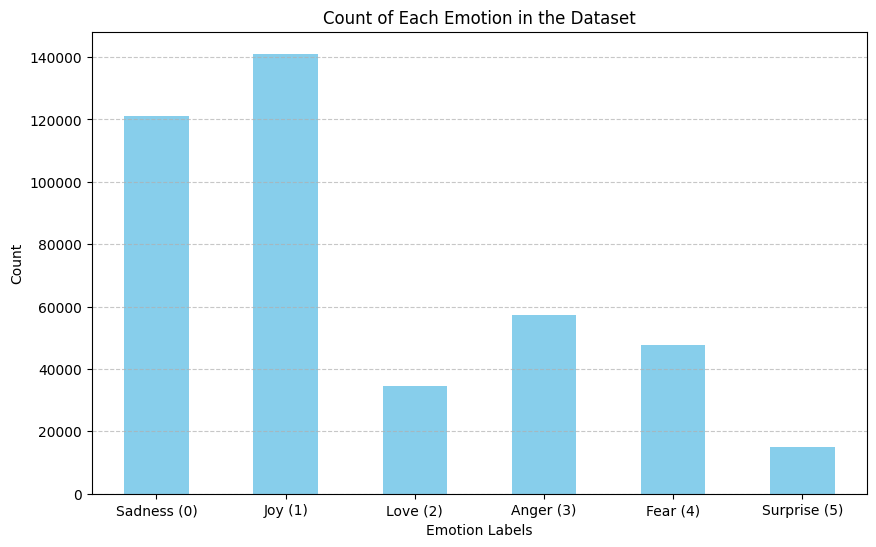

In [ ]:
import matplotlib.pyplot as plt

# Count the number of instances for each emotion label
emotion_counts = emotions_data['label'].value_counts().sort_index()

# Plotting the counts of each emotion
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Each Emotion in the Dataset')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.xticks(ticks=range(6), labels=['Sadness (0)', 'Joy (1)', 'Love (2)', 'Anger (3)', 'Fear (4)', 'Surprise (5)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

# Function to clean text data
def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
emotions_data['text'] = emotions_data['text'].apply(clean_text)

# Split the dataset
train_df, val_df = train_test_split(emotions_data, test_size=0.2, random_state=42)

# Check the result of the split and cleaning
print(train_df.head())


        Unnamed: 0                                               text  label
146122      146122  ive blabbed on enough for tonight im tired and...      0
334806      334806  i woke up really early this morning and drove ...      1
182273      182273  i feel i never gave myself a rest day after th...      3
198898      198898  i am feeling restless teary flat sad and stran...      4
80779        80779        i feel like im doomed before ive even began      0


In [ ]:

from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Initialize tokenizer from the BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define a dataset class for the Emotions data
class EmotionsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = EmotionsDataset(train_df['text'].values, train_df['label'].values, tokenizer)
val_dataset = EmotionsDataset(val_df['text'].values, val_df['label'].values, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)





/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from transformers import BertForSequenceClassification

# Load BERT with the sequence classification head; specify the number of labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)  # Adjust num_labels based on the number of emotion categories



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# Optimization and scheduler setup
epochs = 3
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * epochs  # Define the number of epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):  # Define epochs variable if not defined
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {avg_train_loss:.2f}')






/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.14
Epoch 2, Loss: 0.10
Epoch 3, Loss: 0.09


In [ ]:
# Assuming the training loop has been completed and the model is trained

# Validation function (as defined above)
from sklearn.metrics import classification_report

# To load the model later
# Save the entire model
torch.save(model, '/content/drive/My Drive/Emotion/emotion_model.pth')


def evaluate_model(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels)
    return predictions, true_labels

# Evaluate the model
predictions, true_labels = evaluate_model(model, val_loader, device)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']))


              precision    recall  f1-score   support

     Sadness       0.96      1.00      0.98     24201
         Joy       1.00      0.92      0.95     28164
        Love       0.77      1.00      0.87      6929
       Anger       0.99      0.91      0.95     11441
        Fear       0.87      0.95      0.91      9594
    Surprise       0.89      0.72      0.80      3033

    accuracy                           0.94     83362
   macro avg       0.91      0.92      0.91     83362
weighted avg       0.95      0.94      0.94     83362



In [ ]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,